# Damped pendulum and prediction by SciNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from tqdm import tqdm
from pathlib import Path

## 1. We create data: sinusoidal amortized wave

In [2]:
def data_synthetic_pendulum(kapa, b, timesteps=50, maxtime=5.0, m=1.0, A0=1.0, phi=0.0, t: np.array = None):
    if t is None:
        t = np.linspace(0, maxtime, timesteps)
    w = np.sqrt(kapa / m) * np.sqrt(1 - b**2/(4*m*kapa))
    A = A0 * np.exp(-b * t / (2*m))

    return A * np.cos(w * t + phi)

In [3]:
def plot_synthetic_pendulum(timeserie, timesteps=50, maxtime=5.0):
    t = np.linspace(0, maxtime, timesteps)
    y = timeserie
    plt.figure(figsize=(10, 6))
    plt.plot(t, y)
    plt.title(f'Synthetic Pendulum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

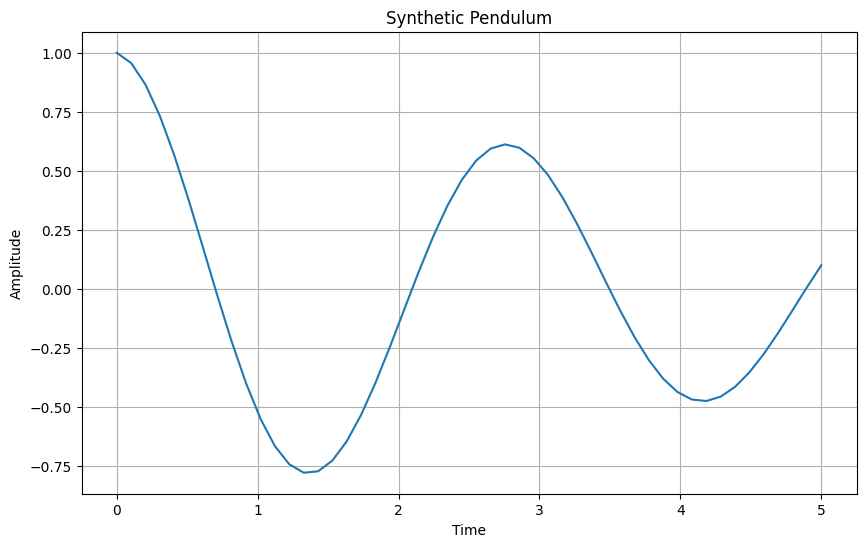

In [23]:
kapa_range = (2.0, 8.0)
b_range = (0.1, 1.0)
kapa = np.random.uniform(*kapa_range)
b = np.random.uniform(*b_range)
pemdulum1 = data_synthetic_pendulum(kapa, b)
plot_synthetic_pendulum(pemdulum1)

In [24]:
def build_dataset(num_samples=1000, kapa_range=(2.0, 8.0), b_range=(0.1, 1.0), question_range=(5.0, 10.0)):
    observations = []
    questions = []
    params = []
    a_corr = []
    for _ in range(num_samples):
        # Build observations
        kapa = np.random.uniform(*kapa_range)
        b = np.random.uniform(*b_range)
        timeserie = data_synthetic_pendulum(kapa, b)
        observations.append(timeserie)
        # Build questions
        question = np.random.uniform(*question_range)
        questions.append(question)
        params.append((kapa, b))
        # Build answer to the question
        a_corr.append(data_synthetic_pendulum(kapa, b, t=question))
    return np.array(observations), np.array(questions), np.array(a_corr), np.array(params)

In [25]:
class PendulumDataset(Dataset):
    def __init__(self, observations, questions, answers, params):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.questions = torch.tensor(questions, dtype=torch.float32)
        self.answers = torch.tensor(answers, dtype=torch.float32)
        self.params = torch.tensor(params, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.questions[idx], self.answers[idx], self.params[idx]

In [26]:
N_samples = 10000
kapa_range = (2.0, 8.0)
b_range = (0.1, 1.0)
observations, questions, answers, params = build_dataset(N_samples, kapa_range, b_range)

dataset = PendulumDataset(observations, questions, answers, params)

In [27]:
train_valid_rate = 0.8
train_size = int(train_valid_rate * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

## 2. Create SciNet

In [28]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

In [29]:
# Test Encoder
batch_size = 10
input_size = 50
latent_size = 3
hidden_sizes = [128, 64]

x = torch.randn((batch_size, input_size))
encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=hidden_sizes)
mean, logvar = encoder(x)

assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

In [30]:
class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1, 
                 output_size: int = 1, 
                 hidden_sizes: list = [64, 32]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z

In [31]:
# Test Decoder
batch_size = 10
latent_size = 3
question_size = 1
hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, latent_size))
question = torch.randn((batch_size, question_size))
decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=hidden_sizes)
possible_answer = decoder(x, question)

assert possible_answer.shape == (batch_size, output_size)

In [32]:
class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1,
                 dec_hidden_sizes: list[int] = [64, 32], 
                 output_size: int = 1
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

In [33]:
# Test PendulumNet

batch_size = 10
input_size
enc_hidden_sizes = [128, 64]
latent_size = 3
question_size = 1
dec_hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

assert possible_answer.shape == (batch_size, output_size)
assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

In [34]:
def scinet_loss(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: int = 1
        ) -> torch.Tensor:

    prediction_loss = nn.MSELoss()(possible_answer, a_corr)
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return prediction_loss + beta * kld_loss

In [35]:
# Test loss function

batch_size = 10
input_size
enc_hidden_sizes = [100, 100]
latent_size = 3
question_size = 1
dec_hidden_sizes = [100, 100]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

a_corr = torch.randn((batch_size, output_size))
beta = 2.0
loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta)

assert loss.item() > 0
assert isinstance(loss.item(), float)
assert loss.dim() == 0

## 3. Training loop

In [36]:
from magnetics_diagnostic_analysis.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [48]:
# Params

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
batch_size1 = len(train_dataset)
batch_size2 = len(valid_dataset)

m_input_size = 50
m_enc_hidden_sizes = [100, 100]
m_latent_size = 3
m_question_size = 1
m_dec_hidden_sizes = [100, 100]
m_output_size = 1

learning_rate = 1e-3
num_epochs = 150
kld_beta = 1.0
es_patience = 10
es_min_delta = 1e-4
gc_max_grad_norm = 1.0
lrs_factor = 0.66
lrs_patience = 4
lrs_min_lr = 1e-5
lrs_min_delta = 1e-4

Using device: cuda


In [49]:
train_loader = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size2, shuffle=False)

In [50]:
pendulum_net = PendulumNet(
    input_size=m_input_size, 
    enc_hidden_sizes=m_enc_hidden_sizes, 
    latent_size=m_latent_size, 
    question_size=m_question_size, 
    dec_hidden_sizes=m_dec_hidden_sizes, 
    output_size=m_output_size
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopping(patience=es_patience, min_delta=es_min_delta)
gradient_clipper = GradientClipping(max_norm=gc_max_grad_norm)
lr_scheduler = LRScheduling(optimizer, factor=lrs_factor, patience=lrs_patience, min_lr=lrs_min_lr, min_delta=lrs_min_delta)

In [51]:
# Training loop

def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 1.0, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:
    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20}{'Train Loss':<15}{'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for observations, questions, a_corr, _ in tqdm(train_loader, desc="Training", leave=False):
            observations = observations.to(device)
            questions = questions.to(device).unsqueeze(-1)
            a_corr = a_corr.to(device).unsqueeze(-1)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, a_corr, _ in tqdm(valid_loader, desc="Validation", leave=False):
                observations = observations.to(device)
                questions = questions.to(device).unsqueeze(-1)
                a_corr = a_corr.to(device).unsqueeze(-1)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}{train_loss:<15.6f}{valid_loss:<15.6f}")

        if early_stopper:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler:
            lr_scheduler.step(valid_loss)

        path = Path().absolute() / 'pendulum_scinet.pth'
        torch.save(model.state_dict(), path)
    
    return history

In [52]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=num_epochs, 
    kld_beta=kld_beta, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler
)

------training on cpu-------

Epoch               Train Loss     Valid Loss     


1/150               53.947327      13.692761      


2/150               53.947262      13.692182      


3/150               53.945744      13.692923      


4/150               53.945232      13.691794      


5/150               53.945950      13.686852      


6/150               53.946167      13.691842      


7/150               53.945545      13.689020      


8/150               53.947266      13.692198      


9/150               53.946331      13.696095      
Reduced learning rate from 1.00e-03 to 6.60e-04


10/150              53.948280      13.687231      


11/150              53.946823      13.692552      


12/150              53.946682      13.691840      


13/150              53.945816      13.692221      
Reduced learning rate from 6.60e-04 to 4.36e-04


14/150              53.948662      13.690933      


15/150              53.946804      13.691952      


16/150              53.945389      13.688170      


17/150              53.947559      13.691095      
Reduced learning rate from 4.36e-04 to 2.87e-04


18/150              53.945889      13.690925      


19/150              53.945629      13.694166      


20/150              53.946503      13.689275      


21/150              53.947411      13.691701      
Reduced learning rate from 2.87e-04 to 1.90e-04


22/150              53.946266      13.687951      


23/150              53.944859      13.692650      


24/150              53.945847      13.691771      


25/150              53.944618      13.691466      
Reduced learning rate from 1.90e-04 to 1.25e-04


26/150              53.947849      13.691431      


27/150              53.945835      13.686010      


28/150              53.946636      13.686164      


29/150              53.945663      13.688350      


30/150              53.948032      13.690140      


31/150              53.946655      13.688818      
Reduced learning rate from 1.25e-04 to 8.27e-05


32/150              53.945652      13.688969      


33/150              53.945843      13.692086      


34/150              53.946327      13.690014      


35/150              53.946484      13.689948      
Reduced learning rate from 8.27e-05 to 5.46e-05


36/150              53.946342      13.687538      


37/150              53.946442      13.693111      


38/150              53.946079      13.692612      


39/150              53.945484      13.692573      
Reduced learning rate from 5.46e-05 to 3.60e-05


40/150              53.946857      13.696064      


41/150              53.945293      13.688186      


42/150              53.945892      13.688704      


43/150              53.946888      13.689771      
Reduced learning rate from 3.60e-05 to 2.38e-05


44/150              53.945900      13.686997      


45/150              53.945507      13.690785      


46/150              53.946175      13.687514      


47/150              53.946198      13.689846      
Reduced learning rate from 2.38e-05 to 1.57e-05


48/150              53.946941      13.691934      


49/150              53.945675      13.692752      


50/150              53.945881      13.690515      


51/150              53.945942      13.691355      
Reduced learning rate from 1.57e-05 to 1.04e-05


52/150              53.945171      13.686479      


53/150              53.945297      13.691503      


54/150              53.947800      13.689337      


55/150              53.946342      13.693634      
Reduced learning rate from 1.04e-05 to 1.00e-05


56/150              53.948082      13.691157      


57/150              53.947792      13.691855      


58/150              53.946190      13.690289      


59/150              53.946136      13.691682      


60/150              53.947083      13.695070      


61/150              53.946754      13.691438      


62/150              53.946445      13.691596      


63/150              53.944935      13.687642      


64/150              53.946209      13.688353      


65/150              53.945366      13.692217      


66/150              53.947227      13.692909      


67/150              53.944267      13.690198      


68/150              53.946117      13.689407      


69/150              53.945675      13.692026      


70/150              53.947342      13.692310      


71/150              53.945385      13.691767      


72/150              53.947155      13.688485      


73/150              53.946503      13.691694      


74/150              53.947189      13.692755      


75/150              53.947113      13.689943      


76/150              53.945923      13.692825      


77/150              53.946602      13.691683      


78/150              53.946213      13.689012      


79/150              53.946556      13.691946      


80/150              53.946869      13.686709      


81/150              53.945560      13.689708      


82/150              53.946629      13.692438      


83/150              53.946827      13.691595      


84/150              53.946671      13.692387      


85/150              53.947037      13.693913      


86/150              53.946629      13.687729      


87/150              53.946991      13.694945      


88/150              53.945946      13.688164      


89/150              53.947124      13.691090      


90/150              53.944283      13.692373      


91/150              53.949738      13.686886      


92/150              53.947868      13.687784      


93/150              53.945251      13.688321      


94/150              53.946499      13.692287      


95/150              53.944485      13.693372      


96/150              53.946217      13.686667      


97/150              53.945999      13.691081      


98/150              53.946732      13.691373      


99/150              53.944901      13.690375      


100/150             53.947170      13.691124      


101/150             53.948753      13.689197      


102/150             53.946476      13.690219      


103/150             53.946079      13.690655      


104/150             53.947952      13.692089      


105/150             53.946980      13.692303      


106/150             53.946136      13.687732      


107/150             53.946445      13.687762      


108/150             53.947910      13.687279      


109/150             53.947571      13.689671      


110/150             53.947830      13.692134      


111/150             53.948620      13.691166      


112/150             53.947441      13.694129      


113/150             53.946529      13.690329      


114/150             53.945869      13.693251      


115/150             53.946503      13.689020      


116/150             53.946270      13.695001      


117/150             53.945648      13.688239      


118/150             53.947693      13.692049      


119/150             53.944763      13.693406      


120/150             53.945419      13.689754      


121/150             53.946747      13.691026      


122/150             53.946175      13.688484      


123/150             53.946194      13.688065      


124/150             53.948391      13.691977      


125/150             53.947979      13.693285      


126/150             53.946682      13.693046      


127/150             53.944031      13.690483      


128/150             53.947792      13.687525      


129/150             53.948597      13.689267      


130/150             53.947372      13.693429      


131/150             53.945293      13.686920      


132/150             53.945984      13.689587      


133/150             53.944904      13.690549      


134/150             53.947250      13.690277      


135/150             53.946850      13.691807      


136/150             53.945599      13.691857      


137/150             53.947922      13.690299      


138/150             53.947163      13.689087      


139/150             53.947285      13.691148      


140/150             53.946598      13.689707      


141/150             53.945473      13.688889      


142/150             53.945808      13.687739      


143/150             53.946491      13.695838      


144/150             53.947887      13.694118      


145/150             53.946308      13.689434      


146/150             53.946854      13.695595      


147/150             53.947552      13.695048      


148/150             53.946854      13.688948      


149/150             53.946960      13.689648      


150/150             53.947025      13.691856      


In [ ]:
path = Path().absolute() / 'pendulum_scinet.pth'
torch.save(pendulum_net.state_dict(), path)

In [ ]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    path = Path(__file__).absolute().parent.parent.parent.parent / "results/figures/mscred/last_training_history.png"
    plt.savefig(path)
    return None

## 4. Test on one example

In [ ]:
kapa_range = (2.0, 8.0)
b_range = (0.1, 1.0)
kapa = np.random.uniform(*kapa_range)
b = np.random.uniform(*b_range)
pemdulum1 = data_synthetic_pendulum(kapa, b)
plot_synthetic_pendulum(pemdulum1)